# import stuff 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import objectives
from keras.datasets import mnist
from keras import backend as K

Using TensorFlow backend.


# encoder/decode network size

In [121]:
batch_size=100
digit_size= 32
original_dim=3072
intermediate_dim=256
latent_dim=2
nb_epochs= 50
epsilon_std=1.0

# encoder

In [122]:
X=Input(batch_shape=(batch_size,original_dim))
h=Dense(intermediate_dim, activation='relu')(X)
z_mean=Dense(latent_dim)(h)
z_log_var=Dense(latent_dim)(h)

# sampling from latent for decoder

In [123]:
def sampling(args):
    _mean,_log_var=args
    epsilon=K.random_normal(shape=(batch_size, latent_dim), mean=0.)
    return _mean+K.exp(_log_var/2)*epsilon

# a keras lambda layer computes arbitrary function on the output of a layer
# so z is effectively combining mean and variance layers through sampling func 
z= Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# decoder

In [124]:
h_decoder=Dense(intermediate_dim, activation='relu')
X_bar=Dense(original_dim,activation='sigmoid')

# we instantiate these layers separately so as to reuse them later
h_decoded = h_decoder(z)
X_decoded = X_bar(h_decoded)

# VAE loss

In [125]:
def vae_loss(x,x_bar):
    reconst_loss=original_dim*objectives.binary_crossentropy(x, x_bar)
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return reconst_loss + kl_loss

# compile model and prepare data for training

In [126]:
from keras.datasets import cifar10
# build and compile model
vae=Model(X , X_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
train_picks = np.ravel(np.logical_or(y_train==3,y_train==5))  
test_picks = np.ravel(np.logical_or(y_test==3,y_test==5))


y_train = np.array(y_train[train_picks]==5,dtype=int)
y_test = np.array(y_test[test_picks]==5,dtype=int)
x_train = x_train[train_picks]
x_test = x_test[test_picks]

# normalize input and make them float32 to run on GPU
x_train=x_train.astype('float32')/ 255.
x_test=x_test.astype('float32')/255.

x_train=x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test=x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))



# train model based on the loss func we defined

In [127]:
# x_train is required for input and loss output as target
vae.fit(x_train,x_train, shuffle=True, nb_epoch=nb_epochs, batch_size=batch_size, validation_data=(x_test, x_test))

C:\Users\ta\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 10000 samples, validate on 2000 samples
Epoch 1/50
10000/10000 [==============================] - 12s 1ms/step - loss: 2066.5100 - val_loss: 2023.4843
Epoch 2/50
10000/10000 [==============================] - 5s 550us/step - loss: 2008.9227 - val_loss: 1999.9491
Epoch 3/50
10000/10000 [==============================] - 5s 503us/step - loss: 1984.9599 - val_loss: 1981.3816
Epoch 4/50
10000/10000 [==============================] - 5s 500us/step - loss: 1972.0040 - val_loss: 1975.7813
Epoch 5/50
10000/10000 [==============================] - 5s 497us/step - loss: 1969.0828 - val_loss: 1974.4658
Epoch 6/50
10000/10000 [==============================] - 5s 498us/step - loss: 1968.3517 - val_loss: 1973.4263
Epoch 7/50
10000/10000 [==============================] - 5s 494us/step - loss: 1967.8778 - val_loss: 1973.3389
Epoch 8/50
10000/10000 [==============================] - 5s 497us/step - loss: 1967.5403 - val_loss: 1973.2221
Epoch 9/50
10000/10000 [==============================] 

# Let's play with inference and the generative models we trained!

The encoder network can embed the 28x28 images in its latent space. As you can see, it can even cluster them!

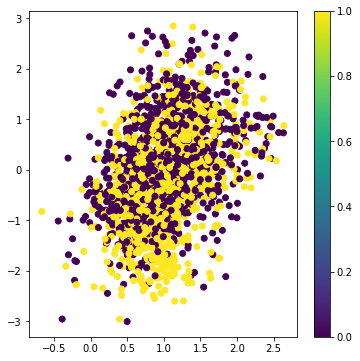

In [128]:
# encoder is the inference network
encoder=Model(X, z_mean)

# a 2d plot of 10 digit classes in latent space
x_test_encoded=encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test)
plt.colorbar()
plt.show()

In [144]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
train_picks = np.ravel(np.logical_or(Y_train==3,Y_train==5))  
test_picks = np.ravel(np.logical_or(Y_test==3,Y_test==5))


Y_train = np.array(Y_train[train_picks]==5,dtype=int)
Y_test = np.array(Y_test[test_picks]==5,dtype=int)
X_train = X_train[train_picks]
X_test = X_test[test_picks]

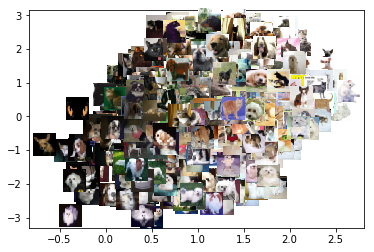

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

def main():
    x = x_test_encoded[:, 0]
    y = x_test_encoded[:, 1]
#     image_path = get_sample_data('ada.png')
    fig, ax = plt.subplots()

    imscatter( x, y, X_test, zoom=0.7, ax=ax)
    lines = ax.plot(x, y)
    lines.pop(0).remove()
    plt.show()

def imscatter(x, y, image, ax=None, zoom=1.0):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = []
    for i in image:
#         print(i)
        im.append(OffsetImage(i, zoom=zoom))
#     print(im)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0,img in zip(x, y,im):
        
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

main()